### This notebook was used to convert the original EQTransformer weights to SeisBench and ensure binary compatibility. It is not intended for further use, but only serves as a reference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seisbench.models import EQTransformer
from seisbench.models.eqtransformer import CustomLSTM, ActivationLSTMCell
import torch
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential

Using TensorFlow backend.


In [106]:
model = EQTransformer(original_compatible=True)

In [107]:
# model.to('cuda:0')

In [108]:
wv = torch.rand(20, 3, 6000, device=model.device)

In [109]:
det, p, s, _ = model(wv)

In [110]:
s.shape

torch.Size([20, 6000])

In [111]:
print("Total number of param vectors:", len(list(model.parameters())))
print("Total number of params:", sum(p.numel() for p in model.parameters()))

Total number of param vectors: 198
Total number of params: 376935


In [112]:
def list_weights(path):
    """
    Lists the weights and their shapes in a hdf5 file
    :return: dict[weight_path, shape]
    """

    def traverse(root):
        if isinstance(root, h5py.Dataset):
            return {root.name: root[()]}
        else:
            out = {}
            for key in root.keys():
                out.update(traverse(root[key]))
            return out

    with h5py.File(path, "r") as f:
        return traverse(f["model_weights"])

In [113]:
tf_state_dict = list_weights("/home/munchmej/code/EQTransformer/ModelsAndSampleData/EqT_model.h5")

In [114]:
pt_state_dict = model.state_dict()

In [115]:
def compare_dicts_by_shape(a, b):
    """
    Finds all entries of a that do not have a shape equivalent in b and vice versa
    """
    
    a_shapes = set(tuple(x.shape) for x in a.values())
    b_shapes = set(tuple(x.shape) for x in b.values())
    
    print('A but not B')
    for key, val in a.items():
        if tuple(val.shape) not in b_shapes:
            print(key, val.shape)
            
    print()
    print('B but not A')
    for key, val in b.items():
        if tuple(val.shape) not in a_shapes:
            print(key, val.shape)

In [116]:
compare_dicts_by_shape(tf_state_dict, pt_state_dict)

A but not B
/model_weights/bidirectional_1/bidirectional_1/backward_lstm_1/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/backward_lstm_2/kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/backward_lstm_2/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/forward_lstm_2/kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/forward_lstm_2/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_3/bidirectional_3/backward_lstm_3/kernel:0 (16, 64)
/model_weights/bidirectional_3/bidirectional_3/backward_lstm_3/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_3/bidirectional_3/forward_lstm_3/kernel:0 (16, 64)
/model_weights/bidirectional_3/bidirectional_3/forward_lstm_3/recurrent_kernel:0 (16, 64)
/model_weights/conv1d_1/conv1d_1/kernel:0 (11, 3, 8)
/model_weights/conv1d_10/conv1d_10/kernel:0 (3, 64, 64)
/model_weights

In [117]:
lstm = model.bi_lstm_stack.members[0].lstm

In [118]:
lstm_dict = lstm.state_dict()
for key, val in lstm_dict.items():
    print(key, tuple(val.shape))

cell_f.weight_ih (64, 64)
cell_f.weight_hh (64, 16)
cell_f.bias_ih (64,)
cell_f.bias_hh (64,)
cell_b.weight_ih (64, 64)
cell_b.weight_hh (64, 16)
cell_b.bias_ih (64,)
cell_b.bias_hh (64,)


In [150]:
new_state_dict = {}

In [151]:
# Copy encoder

for key in model.encoder.state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 1
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        # For input layer, resort channels from ENZ to ZNE
        if conv_id == 1:
            data = data[:, [2, 1, 0], :]
            
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
        
    new_state_dict["encoder." + key] = torch.tensor(data)

In [152]:
# Copy res CNN

norm_dict = {'weight': 'gamma',
             'bias': 'beta',
             'running_mean': 'moving_mean',
             'running_var': 'moving_variance'}

for key in model.res_cnn_stack.state_dict():
    _, member_id, layer, t = key.split('.')
    
    if layer[:4] == "conv":
        conv_id = 7 + 2 * int(member_id) + int(layer[-1:])
        source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
        if t == "weight":
            data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
        
    elif layer[:4] == "norm":
        norm_id = 2 * int(member_id) + int(layer[-1:])
        if t == 'num_batches_tracked':
            data = model.res_cnn_stack.state_dict()[key]
        else:
            source = f"/model_weights/batch_normalization_{norm_id}/batch_normalization_{norm_id}/{norm_dict[t]}:0"
            data = tf_state_dict[source]
        
    out_key = "res_cnn_stack." + key
    new_state_dict[out_key] = torch.tensor(data)
    # print(data.shape, model.res_cnn_stack.state_dict()[key].shape)

In [153]:
# Copy BiLSTMStack

for key in model.bi_lstm_stack.state_dict():
    parts = key.split('.')
    if len(parts) == 4:
        _, member_id, layer, t = key.split('.')
    else:
        _, member_id, layer, cell, t = key.split('.')
    
    if layer == "conv":
        conv_id = 22 + int(member_id)
        source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
        if t == "weight":
            data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
            
    elif layer == "norm":
        norm_id = 15 + int(member_id)
        if t == 'num_batches_tracked':
            data = model.bi_lstm_stack.state_dict()[key]
        else:
            source = f"/model_weights/batch_normalization_{norm_id}/batch_normalization_{norm_id}/{norm_dict[t]}:0"
            data = tf_state_dict[source]
            
    elif layer == "lstm":
        if cell[-1] == "f":
            direction = "forward"
        else:
            direction = "backward"
        lstm_id = int(member_id) + 1
        
        source = f"/model_weights/bidirectional_{lstm_id}/bidirectional_{lstm_id}/{direction}_lstm_{lstm_id}/"
        
        # Split bias 0.5/0.5
        # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
        if t.startswith("weight_ih"):
            data = tf_state_dict[source + "kernel:0"].T
        elif t.startswith("weight_hh"):
            data = tf_state_dict[source + "recurrent_kernel:0"].T
        elif t.startswith("bias_hh"):
            data = 0.5 * tf_state_dict[source + "bias:0"]
        else:
            # bias_ih
            data = 0.5 * tf_state_dict[source + "bias:0"]
            
    
    out_key = "bi_lstm_stack." + key
    new_state_dict[out_key] = torch.tensor(data)

In [154]:
# Copy transformer_d0

ff_dict = {"weight": "W", "bias": "b"}

for key in model.transformer_d0.state_dict():
    if key[:2] == "ff":
        _, layer, t = key.split('.')
        lin_id = int(layer[-1:])
        source = f"/model_weights/feed_forward_1/feed_forward_1/feed_forward_1_{ff_dict[t]}{lin_id}:0"
        data = tf_state_dict[source]
        if t == "weight":
            data = data.T
        
    else:
        layer, t = key.split('.')
        
        if layer == "attention":
            source = f"/model_weights/attentionD0/attentionD0/attentionD0_Add_{t}:0"
            data = tf_state_dict[source]
        elif layer.startswith("norm"):
            norm_id = int(layer[-1:])
            source = f"/model_weights/layer_normalization_{norm_id}/layer_normalization_{norm_id}/{t}:0"
            data = tf_state_dict[source]
            data = np.expand_dims(data, axis=-1)
        
    new_state_dict["transformer_d0." + key] = torch.tensor(data)

In [155]:
# Copy transformer_d

ff_dict = {"weight": "W", "bias": "b"}

for key in model.transformer_d.state_dict():
    if key[:2] == "ff":
        _, layer, t = key.split('.')
        lin_id = int(layer[-1:])
        source = f"/model_weights/feed_forward_2/feed_forward_2/feed_forward_2_{ff_dict[t]}{lin_id}:0"
        data = tf_state_dict[source]
        if t == "weight":
            data = data.T
        
    else:
        layer, t = key.split('.')
        
        if layer == "attention":
            source = f"/model_weights/attentionD/attentionD/attentionD_Add_{t}:0"
            data = tf_state_dict[source]
        elif layer.startswith("norm"):
            norm_id = int(layer[-1:]) + 2
            source = f"/model_weights/layer_normalization_{norm_id}/layer_normalization_{norm_id}/{t}:0"
            data = tf_state_dict[source]
            data = np.expand_dims(data, axis=-1)
        
    new_state_dict["transformer_d." + key] = torch.tensor(data)

In [156]:
# Copy decoder_d

for key in model.decoder_d.state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 25
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
        
    new_state_dict["decoder_d." + key] = torch.tensor(data)

In [157]:
# Copy pick lstm 0 (P)

for key in model.pick_lstms[0].state_dict():
    _, t = key.split(".")
    
    source = f"/model_weights/lstm_4/lstm_4/"

    # Split bias 0.5/0.5
    # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
    if t.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif t.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    else:
        data = tf_state_dict[source + "bias:0"] * 0.5
            
    out_key = "pick_lstms.0." + key
    new_state_dict[out_key] = torch.tensor(data)

In [158]:
# Copy pick lstm 1 (S)

for key in model.pick_lstms[1].state_dict():
    _, t = key.split(".")
    
    source = f"/model_weights/lstm_5/lstm_5/"

    # Split bias 0.5/0.5
    # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
    if t.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif t.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    else:
        data = tf_state_dict[source + "bias:0"] * 0.5
            
    out_key = "pick_lstms.1." + key
    new_state_dict[out_key] = torch.tensor(data)

In [159]:
# Copy attention 0 (P)

for key in model.pick_attentions[0].state_dict():
    t = key
        
    source = f"/model_weights/attentionP/attentionP/attentionP_Add_{t}:0"
    data = tf_state_dict[source]
        
    new_state_dict["pick_attentions.0." + key] = torch.tensor(data)

In [160]:
# Copy attention 1 (S)

for key in model.pick_attentions[1].state_dict():
    t = key
        
    source = f"/model_weights/attentionS/attentionS/attentionS_Add_{t}:0"
    data = tf_state_dict[source]
        
    new_state_dict["pick_attentions.1." + key] = torch.tensor(data)

In [161]:
# Copy decoder 0 (P)

for key in model.pick_decoders[0].state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 32
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
        
    new_state_dict["pick_decoders.0." + key] = torch.tensor(data)

In [162]:
# Copy decoder 1 (S)

for key in model.pick_decoders[1].state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 39
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
        
    new_state_dict["pick_decoders.1." + key] = torch.tensor(data)

In [163]:
# Copy final layers
data = np.transpose(tf_state_dict["/model_weights/picker_P/picker_P/kernel:0"], (2, 1, 0))
new_state_dict["pick_convs.0.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/picker_P/picker_P/bias:0"]
new_state_dict["pick_convs.0.bias"] = torch.tensor(data)

data = np.transpose(tf_state_dict["/model_weights/picker_S/picker_S/kernel:0"], (2, 1, 0))
new_state_dict["pick_convs.1.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/picker_S/picker_S/bias:0"]
new_state_dict["pick_convs.1.bias"] = torch.tensor(data)

data = np.transpose(tf_state_dict["/model_weights/detector/detector/kernel:0"], (2, 1, 0))
new_state_dict["conv_d.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/detector/detector/bias:0"]
new_state_dict["conv_d.bias"] = torch.tensor(data)

In [164]:
len(new_state_dict)

249

In [165]:
len(pt_state_dict)

249

In [166]:
for key in new_state_dict.keys():
    if pt_state_dict[key].shape != new_state_dict[key].shape:
        print(key, pt_state_dict[key].shape, new_state_dict[key].shape)

In [167]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [168]:
torch.save(model.state_dict(), "/home/munchmej/.seisbench/models/eqtransformer/original.pt")

In [137]:
model

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1,

In [138]:
import seisbench.data

In [182]:
dummy = seisbench.data.DummyDataset(component_order='ENZ')

In [183]:
wv = dummy.get_waveforms([np.random.randint(100)], sampling_rate=100)

wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)

In [184]:
with h5py.File("/home/munchmej/code/EQTransformer/ModelsAndSampleData/100samples.hdf5", "r") as f:
    wv = f['data']['109C.TA_20060723155859_EV'][()]
    
wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)
wv = wv.T.reshape(1, 3, 6000)

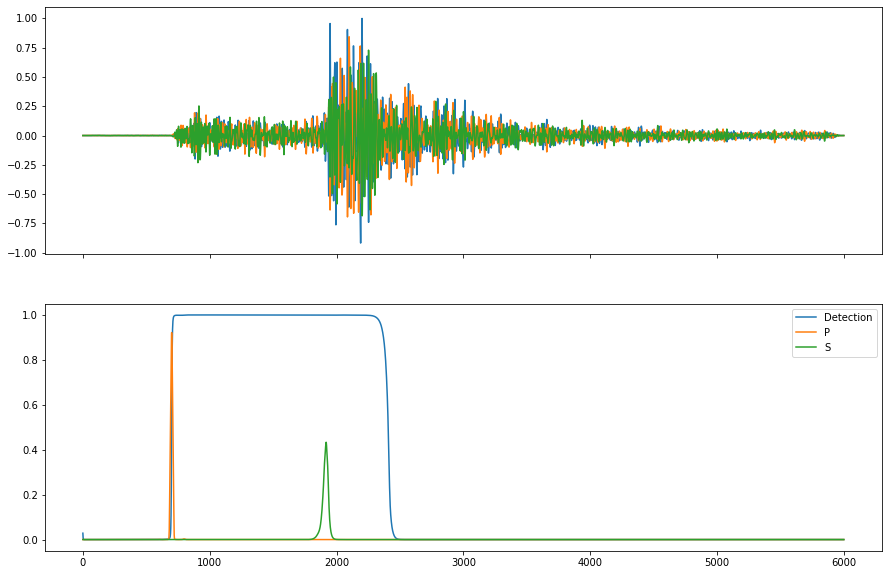

In [185]:
model.eval()
with torch.no_grad():
    det, p, s, _ = model(torch.tensor(wv[:, [2, 1, 0]], dtype=torch.float32))
    det = det.numpy()
    p = p.numpy()
    s = s.numpy()

fig = plt.figure(figsize=(15, 10))
ax, ax2 = fig.subplots(2, 1, sharex=True)

ax.plot(wv[0, 0])
ax.plot(wv[0, 1])
ax.plot(wv[0, 2])
ax2.plot(det[0], label="Detection")
ax2.plot(p[0], label="P")
ax2.plot(s[0], label="S")
# ax2.plot(p[0] / np.max(p[0, 100:-100]), label="P")
# ax2.plot(s[0] / np.max(s[0, 100:-100]), label="S")
ax2.set_ylim(-0.05, 1.05)
ax2.legend()

In [52]:
from keras.models import load_model
from keras.layers import Dropout, Lambda

from EQTransformer.core.EqT_utils import SeqSelfAttention, FeedForward, f1, LayerNormalization

class DropoutMock(Dropout):
    def __init__(self, *arg, **kwargs):
        super().__init__(rate=0)

custom_objects = {'SeqSelfAttention': SeqSelfAttention, 'FeedForward': FeedForward, 'f1': f1, 'LayerNormalization': LayerNormalization, 'SpatialDropout1D': DropoutMock}
tf_model = load_model('/home/munchmej/code/EQTransformer/ModelsAndSampleData/EqT_model.h5', custom_objects=custom_objects)

In [53]:
from keras.optimizers import Adam

In [171]:
tf_model.compile(optimizer=Adam())

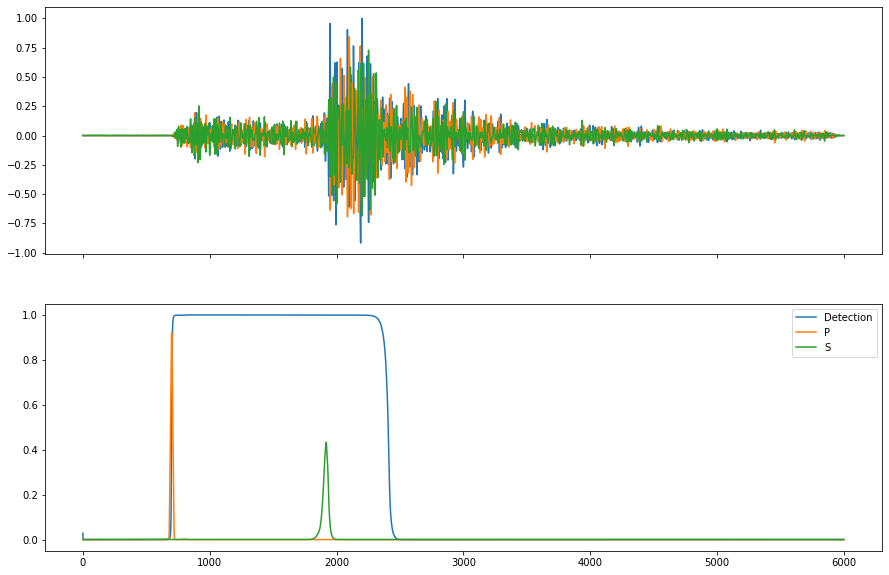

In [186]:
tf_det, tf_p, tf_s = tf_model.predict(np.transpose(wv, (0, 2, 1)))

fig = plt.figure(figsize=(15, 10))
ax, ax2 = fig.subplots(2, 1, sharex=True)

ax.plot(wv[0, 0])
ax.plot(wv[0, 1])
ax.plot(wv[0, 2])
ax2.plot(tf_det[0, :, 0], label="Detection")
ax2.plot(tf_p[0, :, 0], label="P")
ax2.plot(tf_s[0, :, 0], label="S")
ax2.set_ylim(-0.05, 1.05)
ax2.legend()

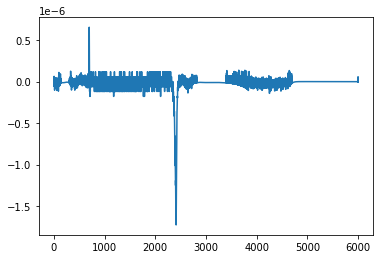

In [187]:
plt.plot(tf_det[0, :, 0] - det[0, :])

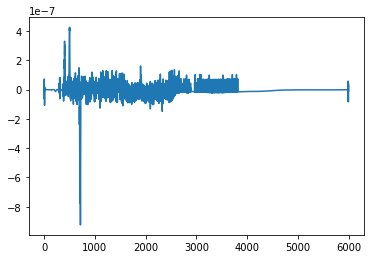

In [188]:
plt.plot(tf_p[0, :, 0] - p[0, :])

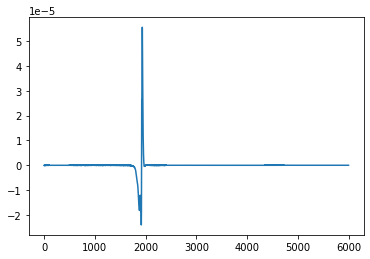

In [189]:
plt.plot(tf_s[0, :, 0] - s[0, :])

In [59]:
# With a Keras function
get_all_layer_outputs = K.function([tf_model.layers[0].input] + [K.learning_phase()],
                                   [l.output for l in tf_model.layers])

layer_output = get_all_layer_outputs([np.transpose(wv, (0, 2, 1))] + [0]) # return the same thing

In [60]:
len(layer_output)

151

In [61]:
len(tf_model.layers)

151

In [62]:
for i, layer in enumerate(tf_model.layers):
    print(i, layer.name)

0 input
1 conv1d_1
2 max_pooling1d_1
3 conv1d_2
4 max_pooling1d_2
5 conv1d_3
6 max_pooling1d_3
7 conv1d_4
8 max_pooling1d_4
9 conv1d_5
10 max_pooling1d_5
11 conv1d_6
12 max_pooling1d_6
13 conv1d_7
14 max_pooling1d_7
15 batch_normalization_1
16 activation_1
17 dropout_mock_1
18 conv1d_8
19 batch_normalization_2
20 activation_2
21 dropout_mock_2
22 conv1d_9
23 add_1
24 batch_normalization_3
25 activation_3
26 dropout_mock_3
27 conv1d_10
28 batch_normalization_4
29 activation_4
30 dropout_mock_4
31 conv1d_11
32 add_2
33 batch_normalization_5
34 activation_5
35 dropout_mock_5
36 conv1d_12
37 batch_normalization_6
38 activation_6
39 dropout_mock_6
40 conv1d_13
41 add_3
42 batch_normalization_7
43 activation_7
44 dropout_mock_7
45 conv1d_14
46 batch_normalization_8
47 activation_8
48 dropout_mock_8
49 conv1d_15
50 add_4
51 batch_normalization_9
52 activation_9
53 dropout_mock_9
54 conv1d_16
55 batch_normalization_10
56 activation_10
57 dropout_mock_10
58 conv1d_17
59 add_5
60 batch_normaliza

In [94]:
model.eval()
with torch.no_grad():
    det, p, s, layerout = model(torch.tensor(wv, dtype=torch.float32))
    layerout = layerout.numpy()

In [95]:
layer_idx = 118
print(tf_model.layers[layer_idx])
tf_out = layer_output[layer_idx]
print(tf_out.shape)

(1, 376, 32)


In [96]:
layerout[0].T

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.10411607],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.15269679],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.16697207],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [97]:
tf_out[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.10411607],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.1526968 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.16697209],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

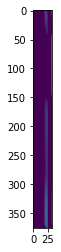

In [98]:
plt.imshow(tf_out[0])

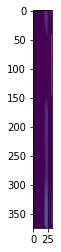

In [99]:
plt.imshow(layerout[0].T)

In [100]:
diff = tf_out[0] - layerout[0].T
cb = plt.imshow(diff)
plt.colorbar(cb)
print(np.max(np.abs(diff)))

ValueError: operands could not be broadcast together with shapes (376,32) (375,32) 

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
idx = 12

ax.plot(layerout[0, idx], label='pytorch')
ax.plot(tf_out[0, :, idx], label='tf')
ax.legend()

In [246]:
layer = tf_model.layers[layer_idx]

In [247]:
layer.get_config()

{'name': 'lstm_5',
 'trainable': True,
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'units': 16,
 'activation': 'tanh',
 'recurrent_activation': 'hard_sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'unit_forget_bias': True,
 'kernel_regularizer': None,
 'recurrent_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'recurrent_constraint': None,
 'bias_constraint': None,
 'dropout': 0.1,
 'recurrent_dropout': 0.1,
 'implementation': 1}